In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from pomegranate import *
from scipy import stats

import config
import utility.df
import utility.iolib
import utility.plotlib
import model.performance

from utility.feature import Feature
from utility.feature import FeatureCM
from model.dataEngine import DataEngine
from model.featureConfig import FeatureConfig_G1
from model.featureConfig import FeatureConfig_G2
from model.featureConfig import FeatureConfig_G3
from model.mixtureModel import ModelParam
from model.mixtureModel import GroupConfig
from model.mixtureModel import MixtureModel

## Configuration and Data Loading

In [2]:
# Setup configuration
cfg = config.ResearchConfig_MonOnly
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=cfg.MONTHLY_ONLY)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

Complete loading data for subscription and lesson history!
By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

We also choose to remove 2525 annual subscribers. 

In summary, there are 3013/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 2672/2672 [00:02<00:00, 915.49it/s] 


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved in a file. The file has been loaded!


## Features Preparation

In [3]:
data_engine = DataEngine(df_subspt1, df_datesFrame, df_lesson1, df_incomp1, df_pupils, cfg)
data_engine.aggregate_features()

Construct feature object.
+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: math age.
+ Add feature: outcome.
Start binning stackDepth for complete lesson table.
Start binning stackDepth for incomplete lesson table.
+ Add feature: hardship.
+ Add feature: mark.
Aggregate data over customer months.


100%|██████████| 49/49 [00:22<00:00,  2.14it/s]


In [4]:
df_whizz1 = data_engine.df_whizz_

## Groups

In [5]:
mask_churn = df_whizz1.churn==1

mask_inactive = df_whizz1.active==0

print('Churn rate for inactive subscribers = {:.2f}%.'.\
      format(df_whizz1[mask_inactive&mask_churn].shape[0]/df_whizz1[mask_inactive].shape[0]*100))
print('Churn rate for active subscribers = {:.2f}%.'.\
      format(df_whizz1[~mask_inactive&mask_churn].shape[0]/df_whizz1[~mask_inactive].shape[0]*100))

mask_noassess = (df_whizz1.assess==0) & (df_whizz1.active==1)
print('Churn rate for subscribers having no assessment = {:.2f}%.'.\
      format(df_whizz1[mask_noassess&mask_churn&~mask_inactive].shape[0]/\
             df_whizz1[mask_noassess&~mask_inactive].shape[0]*100))
print('Churn rate for subscribers having assessment = {:.2f}%.'.\
      format(df_whizz1[~mask_noassess&mask_churn&~mask_inactive].shape[0]/\
             df_whizz1[~mask_noassess&~mask_inactive].shape[0]*100))

mask_fine = ~mask_inactive & ~mask_noassess

print('Churn rate for good-quality subscribers = {:.2f}%.'.\
      format(df_whizz1[mask_fine&mask_churn].shape[0]/\
             df_whizz1[mask_fine].shape[0]*100))
print('Churn rate for not good-quality subscribers = {:.2f}%.'.\
      format(df_whizz1[~mask_fine&mask_churn].shape[0]/\
             df_whizz1[~mask_fine].shape[0]*100))
print('Churn rate for all subscribers = {:.2f}%.'.\
      format(df_whizz1[mask_churn].shape[0]/\
             df_whizz1.shape[0]*100))

Churn rate for inactive subscribers = 22.99%.
Churn rate for active subscribers = 10.46%.
Churn rate for subscribers having no assessment = 16.94%.
Churn rate for subscribers having assessment = 10.21%.
Churn rate for good-quality subscribers = 10.21%.
Churn rate for not good-quality subscribers = 22.61%.
Churn rate for all subscribers = 14.96%.


In [6]:
df_whizz_fine = df_whizz1[mask_fine]

## Illustration of benefits of data transformation

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


0.12014020401599161


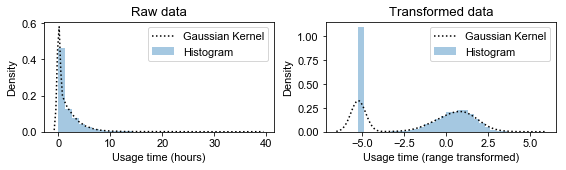

In [7]:
x = df_whizz1['usage'].values + 1
x /= 3600.

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 11

fig = plt.figure(figsize=(8,2.5))
ax = fig.add_subplot(121)
sns.distplot(x, bins=30, kde=True, 
             kde_kws={'linestyle':':', 'color':'k', 'label':'Gaussian Kernel'}, 
             hist_kws={'label':'Histogram'})
ax.set_xlabel('Usage time (hours)')
ax.set_ylabel('Density')
ax.set_title('Raw data')
ax.set_rasterized(True)

ax = fig.add_subplot(122)
xt, l = stats.boxcox(x)
sns.distplot(xt, bins=30, kde=True, 
             kde_kws={'linestyle':':', 'color':'k', 'label':'Gaussian Kernel'},
             hist_kws={'label':'Histogram'})
ax.set_xlabel('Usage time (range transformed)')
ax.set_ylabel('Density')
ax.set_title('Transformed data')
ax.set_rasterized(True)

plt.legend()
plt.tight_layout()
plt.savefig('../../../Result/Plot/BoxCoxTransformation.eps', dpi=500)

print(l)

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


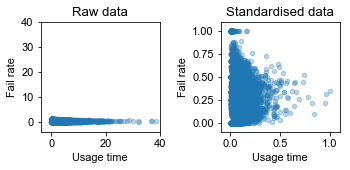

In [8]:
x1 = df_whizz_fine['usage'].values/3600.
x2 = df_whizz_fine.rate_fail.values

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 11

fig = plt.figure(figsize=(5,2.5))
ax = fig.add_subplot(121)
ax.scatter(x1, x2, alpha=0.3, s=20)
ax.set_xlim([-4,40])
ax.set_ylim([-4,40])
ax.set_xlabel('Usage time')
ax.set_ylabel('Fail rate')
ax.set_title('Raw data')
ax.set_rasterized(True)

X = np.vstack([x1, x2])
X = X.transpose()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
Xt = scaler.transform(X)

ax = fig.add_subplot(122)
ax.scatter(Xt[:,0], Xt[:,1], alpha=0.3, s=20)
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])
ax.set_xlabel('Usage time')
ax.set_ylabel('Fail rate')
ax.set_title('Standardised data')
ax.set_rasterized(True)

plt.tight_layout()
plt.savefig('../../../Result/Plot/DataStandardisation.eps', dpi=500)

## Customer month independence

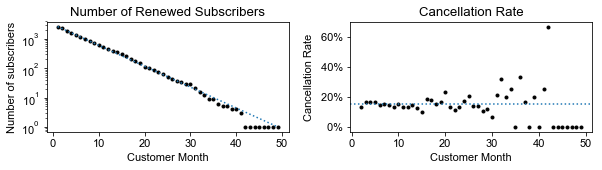

In [9]:
# Population
def survival_customer_month(df_subspt):
    survival_population = df_subspt.groupby('customer_month')['pupilId'].count()
    
    fig = plt.figure(figsize=(8.5,2.5))

    ax = fig.add_subplot(121)
    gmean_survival_rate =  (survival_population.values[-1] /\
       survival_population.values[0])**(1.0 / (survival_population.shape[0]-1))
    survival_theory = np.power(gmean_survival_rate, 
                               range(0, survival_population.shape[0])) *\
                                  survival_population.values[0]
    ax.plot(survival_population, 'ko', markersize=3)
    ax.plot(survival_population.index, survival_theory, ':')
    ax.set_title('Number of Renewed Subscribers')
    ax.set_xlabel('Customer Month')
    ax.set_ylabel('Number of subscribers')
    ax.set_yscale('log')

    ax = fig.add_subplot(122)
    ax.plot(-survival_population.pct_change(), 'ko', markersize=3)
    ax.axhline(y=1-gmean_survival_rate, linestyle=':')
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals]);
    ax.set_xlabel('Customer Month')
    ax.set_ylabel('Cancellation Rate')
    ax.set_title('Cancellation Rate')

    plt.tight_layout()
    plt.savefig('../../../Result/Plot/CancellationRate.eps', dpi=500)

survival_customer_month(df_subspt1)

## Distributions

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


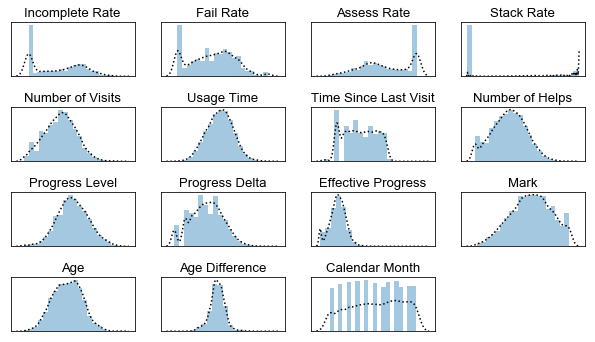

In [10]:
df_whizz_fine = df_whizz1[mask_fine]
df_whizz_fine.drop(columns=['active', 'assess', 'mark_incomplete'], inplace=True)

df_whizz_fine = df_whizz_fine.assign(effective_progress=df_whizz_fine.progress_delta/df_whizz_fine.usage*3600.)

ftr_list_independent = ['rate_incomplete_num',
                        'rate_fail',
                        'rate_assess',
                        'rate_stackDepth23_num', 
                       ]

ftr_list_multivariate = ['num_attempt',
                         'usage',
                         'last_access',
                         'sum_help',
                         'progress', 
                         'progress_delta',
                         'effective_progress', 
                         'mark_complete',
                         'age',
                         'age_diff',
                         'calendar_month',
                        ]

ftr_list = ftr_list_independent + ftr_list_multivariate

ftr_name_list = ['Incomplete Rate', 'Fail Rate', 'Assess Rate', 'Stack Rate',
                 'Number of Visits', 'Usage Time', 'Time Since Last Visit', 'Number of Helps',
                 'Progress Level', 'Progress Delta', 'Effective Progress', 'Mark',
                 'Age', 'Age Difference', 'Calendar Month',
                ]

def feature_distribution(df_whizz, ftr_list, n_col, configuration,
                         ftr_name_list,
                         transform=True, ftr_list_nontransform=[]):
    n_ftr = len(ftr_list)
    n_row = n_ftr // n_col
    n_row +=  n_ftr % n_col
    pos = range(1, n_ftr+1)
    
    warnings.filterwarnings('ignore')

    fig = plt.figure(figsize=(2.1*n_col, 1.2*n_row))
    for i, ftr in enumerate(ftr_list):
        ax = fig.add_subplot(n_row, n_col, pos[i])
        x = df_whizz[ftr].dropna().values # drop NaN for plotting
    
        if (ftr in ftr_list_nontransform) or (not transform):
            sns.distplot(x)
        else:
            # Box-cox transformation can only deal with positive valued data
            # May need to add positive constants to variables to ensure positivity
            if ftr == 'age_diff':
                x += 10.0
            else:
                x += 1
            xt, _ = stats.boxcox(x)
            sns.distplot(xt, bins=20, kde_kws={'linestyle':':', 'color':'k'})
        ax.set_title(ftr_name_list[i])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_rasterized(True)
    
    warnings.filterwarnings('default')

    plt.tight_layout()
    plt.savefig('../../../Result/Plot/FeatureDistribution.eps', dpi=500)

ftr_list_nontransform = []
feature_distribution(
    df_whizz_fine, ftr_list, 4, cfg, ftr_name_list,
    transform=True, ftr_list_nontransform=ftr_list_nontransform)

C:\Users\User\Anaconda3\lib\site-packages\seaborn\palettes.py:727: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


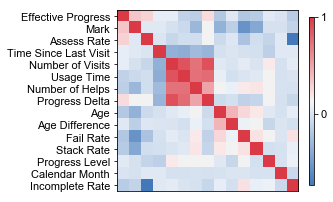

In [11]:
def feature_correlation(df_features, ftr_name_list, size=10):
    import scipy.cluster.hierarchy as sch

    X = df_features.corr().values
    d = sch.distance.pdist(X)       # vector of pairwise distances
    L = sch.linkage(d, method='complete')
    idx = sch.fcluster(L, 0.5*d.max(), 'distance')
    columns = [df_features.columns.tolist()[i] for i in list(np.argsort(idx))]
    ftr_name_list = [ftr_name_list[i] for i in list(np.argsort(idx))]
    df_features = df_features.reindex(columns, axis=1)

    corr = df_features.corr()
    plt.rcParams['font.family'] = 'arial'
    plt.rcParams['font.size'] = 11
    
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap=sns.diverging_palette(250, 10, as_cmap=True))
    #plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    
    plt.xticks([]);
    plt.yticks(range(len(corr.columns)), ftr_name_list);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.5)
    
    plt.tight_layout()
    plt.savefig('../../../Result/Plot/FeatureCorrelation.eps', dpi=500)

feature_correlation(df_whizz_fine[ftr_list], ftr_name_list, size=5)

## Independent features

In [12]:
def independent_component(ftr_str):
    from sklearn.preprocessing import MinMaxScaler
    
    ftrConfig = FeatureConfig_G3()

    ftr_config = eval('ftrConfig.'+ftr_str)
        
    # Define the data to be fitted
    x_raw = df_whizz_fine[ftr_str].values
    x = x_raw * ftr_config.multiplierPre
    x += ftr_config.shiftPre
    # Box-cox transform
    if ftr_config.bcTransform:
        xt, bc_param = stats.boxcox(x)
        x = xt
    x = x.reshape(-1,1)
    # Standardise
    scaler = MinMaxScaler()
    scaler.fit(x)
    x = scaler.transform(x)
    # Post-BoxCox transform
    x *= ftr_config.multiplierPost
    x += ftr_config.shiftPost

    # Define the list of distributions to be mixed
    distribution_list = ftr_config.distributionList

    gmm = GeneralMixtureModel(distribution_list)
    print('Improvement = {}'.format(gmm.fit(x, verbose=False)))
    print('Weights = {}'.format(np.exp(gmm.weights)))
    
    group = gmm.predict(x)
    
    return gmm, group, x

In [13]:
x_list = []
m_list = []
for ftr_str in ftr_list_independent:
    m, g, x = independent_component(ftr_str)
    x_list.append(x)
    m_list.append(m)

Improvement = 3254.9897468088457
Weights = [0.321608   0.16320731 0.4935955  0.02158919]
Improvement = 4665.727973798836
Weights = [0.152151   0.01406478 0.26076983 0.57301439]
Improvement = 4782.621878518301
Weights = [0.25644716 0.11528125 0.56660471 0.06166688]
Improvement = 7482.269497348127
Weights = [0.09835112 0.06319701 0.06011804 0.77833382]


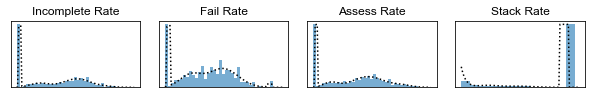

In [14]:
def density_mixtureModel(feature_name, title, feature_data, mixture_model, ax, hist_bin):
    x = feature_data
    xbin = np.arange(x.min()-(x.max()-x.min())/50., x.max()*1.1, 
                     (x.max()-x.min())/hist_bin)
    xs = np.arange(x.min()-(x.max()-x.min())/50., x.max()*1.1, 
                   (x.max()-x.min())/100.)
    prob = mixture_model.probability(xs)

    ax.set_title(title, fontsize=12)
    ax.hist(x, bins=xbin, alpha=0.6, density=True, label='Histogram')
    ax.plot(xs, prob, color='k', linestyle=':', label='Fitted Mixture')

    #ax.set_ylabel("Density", fontsize=12); plt.yticks(fontsize=12)
    #ax.set_xlabel("Value", fontsize=12); plt.yticks(fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_rasterized(True)

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 11
fig = plt.figure(figsize=(8.4, 1.5))
ax = fig.add_subplot(141)
density_mixtureModel('rate_incomplete_num', 'Incomplete Rate', x_list[0], m_list[0], ax, 35)
ax = fig.add_subplot(142)
density_mixtureModel('rate_fail', 'Fail Rate', x_list[1], m_list[1], ax, 35)
ax = fig.add_subplot(143)
density_mixtureModel('rate_assess', 'Assess Rate', x_list[2], m_list[2], ax, 35)
ax = fig.add_subplot(144)
density_mixtureModel('rate_stackDepth23', 'Stack Rate', x_list[3], m_list[3], ax, 12)

#ax = fig.add_subplot(142)
#density_mixtureModel(ftr_str,x,m, ax, 12)

plt.tight_layout()
plt.savefig('../../../Result/Plot/FittingIndependentFeatures.eps', dpi=500)

## Multivariate features

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import mixture

X = np.array(df_whizz_fine[ftr_list_multivariate]+10)
Xt = X
for i in range(0, X.shape[1]):
    xt, _ = stats.boxcox(X[:,i])
    Xt[:, i] = xt
Xt_scaled = MinMaxScaler().fit(Xt).transform(Xt)

y = df_whizz_fine.churn.values

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [16]:
n_components  = 30
n_features = len(ftr_list_multivariate)

#dpgmm = mixture.BayesianGaussianMixture(
#    n_components=n_components, 
#    covariance_type='full',
#    weight_concentration_prior_type='dirichlet_process',
#    covariance_prior=1e0 * np.eye(n_features),
#    init_params="random", tol=1e-6, max_iter=10000, n_init=1, 
#    verbose=2, verbose_interval=100).fit(Xt_scaled)

import pickle
with open('../../../Data/_SavedObject/dpgmm_G3.pkl', 'rb') as inputs:
    dpgmm = pickle.load(inputs)

group_m = dpgmm.predict(Xt_scaled)

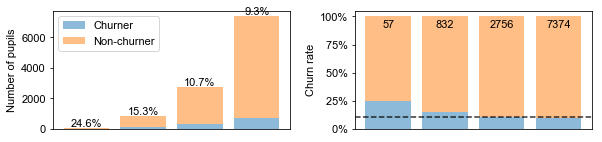

In [17]:
def component_bar(expectations, predictions, n_components):
    num_pupil = []
    num_churn = []
    
    for i in range(0, n_components):
        idx_pupils = np.where(predictions==i)[0]
        if idx_pupils.size > 0: # remove empty groups
            num_pupil.append(idx_pupils.shape[0])
            num_churn.append(expectations[idx_pupils].sum())
        
    df = pd.DataFrame({'num_pupil':num_pupil, 'num_churn':num_churn})
    df = df.assign(rate_churn=df.num_churn/df.num_pupil)
    df.sort_values('rate_churn', ascending=False, inplace=True)
    
    fig = plt.figure(figsize=(8.5,2.1))
    ax = fig.add_subplot(121)
    idx = np.arange(df.shape[0])
    ax.bar(idx, df.num_churn, alpha=0.5, label='Churner')
    rects = ax.bar(idx, df.num_pupil-df.num_churn, bottom=df.num_churn, 
                   alpha=0.5, label='Non-churner')
    ax.set_ylabel('Number of pupils')
    ax.set_xticks([])
    ax.legend()
    ax.set_rasterized(True)
    
    def autolabel(rects, values):
        """Attach a text label above each bar displaying its height
        """
        for rect, value in zip(rects, values):
            if not np.isnan(value):
                height = rect.get_height()
                ax.text(rect.get_x() + rect.get_width()/2., 1.1*height, 
                        '{:.1f}%'.format(value*100), 
                        ha='center', va='bottom')
    
    autolabel(rects, df.rate_churn.values)
    
    ax = fig.add_subplot(122)
    ax.bar(idx, df.rate_churn, alpha=0.5)
    rects = ax.bar(idx, 1-df.rate_churn, bottom=df.rate_churn, alpha=0.5)
    for rect, value in zip(rects, df.num_pupil):
        ax.text(rect.get_x() + rect.get_width()/2., 0.9, 
                '{:d}'.format(value), ha='center')
    base_churn = expectations.sum()/expectations.shape[0]
    ax.axhline(base_churn, linestyle='--', color='k', alpha=0.8)
    ax.set_ylabel('Churn rate')
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals]);
    
    ax.set_xticks([])
    ax.set_rasterized(True)
    
    plt.tight_layout()
    plt.savefig('../../../Result/Plot/ClusteringG3.eps', dpi=500)
    
component_bar(y, group_m, n_components)

In [18]:
n_var_indep = len(ftr_list_independent)
# Combine the group assignemnts from multivariate Gaussian features and independent features
group = []
col_name = []
group.append(group_m)
col_name.append('multi')
for i_var in range(n_var_indep):
    ftr_str = ftr_list_independent[i_var]
    m, g, x = independent_component(ftr_str)
    group.append(g)
    col_name.append('indep'+str(i_var))
    
# Identify unique groups/labels and frequency
label = np.array(group).transpose()
unq_rows, count = np.unique(label, axis=0, return_counts=True)
map_group_count = {tuple(i):j for i,j in zip(unq_rows,count)}

# Compute churn rate within each group
map_group_churn = {}
for k in range(0, len(unq_rows)):
    indices = [i for i, x in enumerate(label.tolist()) if x==unq_rows[k].tolist()]
    l = y[indices]
    map_group_churn[tuple(unq_rows[k])] = l.sum()*1. / len(l)

# Construct the grouping data frame
df_grouping = pd.DataFrame(unq_rows, columns=col_name)
df_grouping = df_grouping.assign(count=count,
                   churn=list(map_group_churn.values()))
df_grouping.sort_values(by='churn', ascending=False, inplace=True)
df_grouping['cumcount'] = df_grouping['count'].cumsum()

Improvement = 3254.9897468088457
Weights = [0.321608   0.16320731 0.4935955  0.02158919]
Improvement = 4665.727973798836
Weights = [0.152151   0.01406478 0.26076983 0.57301439]
Improvement = 4782.621878518301
Weights = [0.25644716 0.11528125 0.56660471 0.06166688]
Improvement = 7482.269497348127
Weights = [0.09835112 0.06319701 0.06011804 0.77833382]


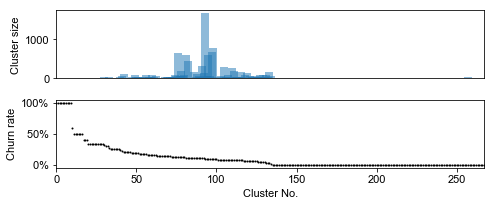

In [19]:
g_size = df_grouping['count'].values
g_churn = df_grouping['churn'].values
fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(211)
ax.bar(range(g_size.shape[0]), g_size, width=5, alpha=.5)
ax.set_xticks([])
ax.set_ylabel('Cluster size')
ax.set_xlim([0,267])
ax.set_rasterized(True)

ax = fig.add_subplot(212)
ax.plot(range(g_size.shape[0]), g_churn, 'ko', markersize=1)
ax.set_xlim([0,267])
ax.set_xlabel('Cluster No.')
ax.set_ylabel('Churn rate')
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals]);

plt.tight_layout()
plt.savefig('../../../Result/Plot/ClusteringG3_Complete.eps', dpi=500)

## Churn Probability Distribution

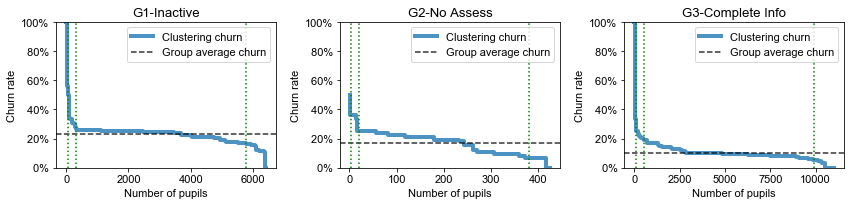

In [21]:
n_trials = 2

#np.random.seed(10)

modelParam_G1 = ModelParam(n_components=10, n_trials=n_trials, n_multi=3, baysian=True)
modelParam_G2 = ModelParam(n_components=3, n_trials=n_trials, n_multi=3, baysian=False)
modelParam_G3 = ModelParam(n_components=10, n_trials=n_trials, n_multi=1, baysian=True)

group_config = GroupConfig(data_engine, modelParam_G1, modelParam_G2, modelParam_G3)

#mixture_model = MixtureModel(group_config)
#mixture_model.fit()
import pickle
with open('../../../Data/_SavedObject/mixture_model2.pkl', 'rb') as inputs:
    mixture_model = pickle.load(inputs)

# Select the best model
map_group_model = mixture_model.map_group_model_
map_group_model_best = mixture_model.select_bestMixtureModel('deviation')

# Plot
utility.plotlib.churn_distribution(mixture_model, ['G1-Inactive','G2-No Assess','G3-Complete Info'])

In [22]:
def individual_churn_prob(map_group_model_best, list_group_name):

    churn_prob = np.array([])
    num_churn = 0.
    num_population = 0.
    for g in list_group_name:
        df_grouping = map_group_model_best[g][0]
        num_churn += (df_grouping['churn'] * df_grouping['count']).sum()
        num_population += df_grouping['count'].sum()
        for idx, row in df_grouping.iterrows():
            prob = row['churn']
            num = row['count']
            array = np.repeat(prob, num)
            churn_prob = np.hstack((churn_prob, array))
            
    return churn_prob, num_churn, num_population

list_gs = [['G1'], ['G2'], ['G3']]
df1 = pd.DataFrame()
for list_g in list_gs:
    churn_prob, _, _ = individual_churn_prob(map_group_model_best, list_g)
    df = pd.DataFrame()
    df = df.assign(x=churn_prob)
    df['g'] = list_g[0] 
    df1 = pd.concat([df1, df], axis=0)

churn_prob_all, _, _ = individual_churn_prob(map_group_model_best, ['G1','G2','G3'])
df = pd.DataFrame()
df = df.assign(x=churn_prob_all)
df['g'] = 'All'
df1 = pd.concat([df1, df], axis=0)

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


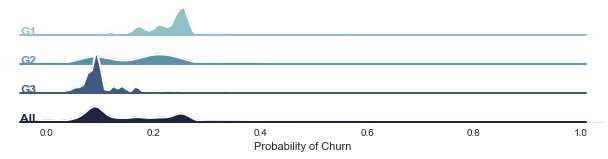

In [23]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)
g = sns.FacetGrid(df1, row="g", hue="g", aspect=15, size=.55, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2)
#g.map(sns.distplot, "x", bins=30, kde_kws={'color':'w', 'lw':1}, hist_kws={'alpha':1})
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.set_xlabels('Probability of Churn')
g.despine(bottom=True, left=True)

# Adjust the axis scope
axes = g.axes
axes[0,0].set_ylim(0,10)
axes[0,0].set_xlim([-0.05,1.01])

plt.tight_layout()
plt.savefig('../../../Result/Plot/ChurnProbability.eps', dpi=500)

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


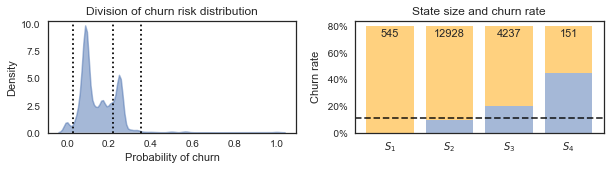

In [77]:
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 11

x = df1[df1['g']=='All']['x'].values
fig = plt.figure(figsize=(8.5,2.5))
ax = fig.add_subplot(121)
sns.kdeplot(x, clip_on=False, shade=True, alpha=.5, lw=1.5)
vs = [0.03, 0.22, 0.35]
for v in vs:
    ax.axvline(v, linestyle=':', color='k')
ax.set_xlabel('Probability of churn')
ax.set_ylabel('Density')
ax.set_title('Division of churn risk distribution')
ax.set_rasterized(True)
    
num_all = []
num_churn = []
ave_churn = []
for i in range(len(vs)+1):
    if i == 0:
        x1 = x[x<=vs[i]]
    elif i < len(vs):
        x1 = x[(x>vs[i-1])&(x<=vs[i])]
    else:
        x1 = x[x>vs[i-1]]
               
    num_all.append(len(x1))
    ave_churn.append(np.mean(x1))
    num_churn.append(num_all[i] * ave_churn[i])

num_all = np.array(num_all)
num_churn = np.array(num_churn)
ave_churn = np.array(ave_churn)

ax = fig.add_subplot(122)
ax.bar(range(len(vs)+1), ave_churn, alpha=0.5)
rects = ax.bar(range(len(vs)+1), 1-ave_churn, bottom=ave_churn, alpha=0.5, color='orange')
for rect, value in zip(rects, num_all):
    ax.text(rect.get_x() + rect.get_width()/2., 0.9, 
                '{:d}'.format(value), ha='center')
#base_churn = expectations.sum()/expectations.shape[0]
ax.axhline(0.14, linestyle='--', color='k', alpha=0.8)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals]);
#ax.set_xticks([])
ax.set_xticks(np.arange(4))
ax.set_xticklabels(('$S_1$', '$S_2$', '$S_3$', '$S_4$'))
ax.set_ylabel('Churn rate')
ax.set_title('State size and churn rate')
ax.set_rasterized(True)

plt.tight_layout()
plt.savefig('../../../Result/Plot/StatesDefinition.eps', dpi=500)

## Transitional analysis

In [78]:
df_churnProb = pd.DataFrame()

list_group_name = ['G1', 'G2', 'G3']
for group_name in list_group_name:
    df_grouping = mixture_model.map_group_model_best_[group_name][0]
    map_group_pupilId = mixture_model.map_group_model_best_[group_name][1]
    map_group_cmonth = mixture_model.map_group_model_best_[group_name][2]
    
    df_churnProb_g = pd.DataFrame()

    for idx, row in df_grouping.iterrows():
        prob = row['churn']
        num = row['count']
        groupId = row['groupId']
    
        # Array of churn probability
        prob_array = np.repeat(prob, num)
        # Array of pupil ID
        pupilId_array = map_group_pupilId[groupId]
        # Array of customer month
        cmonth_array = map_group_cmonth[groupId]
    
        data = {'pupilId': pupilId_array,
                'cmonth': cmonth_array,
                'churnProb': prob_array}
        df = pd.DataFrame(data)
        df_churnProb = pd.concat([df_churnProb, df], axis=0)
    
    df_churnProb = pd.concat([df_churnProb, df_churnProb_g], axis=0)

df_churnProb.sort_values(by=['churnProb'], ascending=False, inplace=True)
df_churnProb.reset_index(inplace=True)
df_churnProb.drop(columns=['index'], inplace=True)

In [102]:
state_anchors = [0.03, 0.22, 0.35]
n_state = len(state_anchors)+1

for i in range(n_state):
    if i==0:
        lower = 0.0
        upper = state_anchors[i]
    elif i==n_state-1:
        lower = state_anchors[i-1]
        upper = 1.0
    else:
        lower = state_anchors[i-1]
        upper = state_anchors[i]
    
    mask = (df_churnProb['churnProb']>=lower) & (df_churnProb['churnProb']<=upper)
    df_churnProb.loc[mask, 'clusterId'] = 'S'+str(i+1)
    
clusterId_list = df_churnProb['clusterId'].unique().tolist()
clusterId_list.append('Churn')

def compute_transitNumber(df_cluter_details, cluster_init, cluster_next):
    c_init = cluster_init
    c_next = cluster_next
    max_cmonth = df_cluter_details['cmonth'].max()
    
    if not cluster_next=='Churn': 
        num_pupils_transit = 0
        for t in range(1, max_cmonth):
            mask_init_t = (df_cluter_details['clusterId']==c_init) & (df_cluter_details['cmonth']==t)
            mask_next_tPlus1 = (df_cluter_details['clusterId']==c_next) & (df_cluter_details['cmonth']==t+1)
            pupils_init_t = df_cluter_details[mask_init_t]['pupilId'].values
            pupils_next_tPlus1 = df_cluter_details[mask_next_tPlus1]['pupilId'].values
            pupils_transit_t = np.intersect1d(pupils_init_t, pupils_next_tPlus1)
            num_pupils_transit += pupils_transit_t.shape[0]
        return num_pupils_transit
    
    num_pupils_vanish = 0
    for t in range(1, max_cmonth):
        mask_init_t = (df_cluter_details['clusterId']==c_init) & (df_cluter_details['cmonth']==t)
        pupils_init_t = df_cluter_details[mask_init_t]['pupilId'].values
        pupils_tPlus1 = df_cluter_details[df_cluter_details['cmonth']==t+1]['pupilId'].values
        pupils_notVanish = np.intersect1d(pupils_init_t, pupils_tPlus1)
        pupils_vanish = np.setdiff1d(pupils_init_t, pupils_notVanish)
        num_pupils_vanish += pupils_vanish.shape[0]
        
    return num_pupils_vanish

df_transition_prob = pd.DataFrame()
n_cluster = len(clusterId_list)

warnings.filterwarnings('ignore')
for c_init in tqdm(clusterId_list):
    num_transit_list = []
    for c_next in clusterId_list:
        num_transit = compute_transitNumber(df_churnProb, c_init, c_next)
        num_transit_list.append(num_transit)

    num_transit_list = np.array(num_transit_list)
    if c_init == 'Cancel':
        prob_transit_list = num_transit_list / num_transit_list.sum()
    else:
        #prob_transit_list = (num_transit_list + 1) / (num_transit_list.sum() + n_cluster)
        prob_transit_list = num_transit_list / num_transit_list.sum()
    
    df = pd.DataFrame()
    df = df.assign(prob=prob_transit_list,
                   count=num_transit_list,
                   cfrom=c_init,
                   cto=clusterId_list)
    
    df_transition_prob = pd.concat([df_transition_prob, df], axis=0)

df_transition_prob.fillna(0., inplace=True)
df_transition_prob.loc[(df_transition_prob['cfrom']=='Churn') & (df_transition_prob['cto']=='Churn'), 'prob'] = 1.

100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


In [103]:
#df_transition_prob.loc[df_transition_prob['prob']<0.05, 'prob'] = 0.0
df_transition_prob.reset_index(inplace=True)

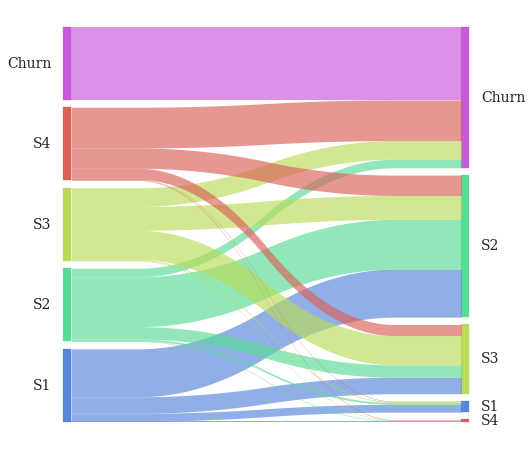

In [122]:
import utility.sankey as sankey
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 11

leftLabels = ['S1', 'S2', 'S3', 'S4', 'Churn']
rightLabels = ['S4', 'S1', 'S3', 'S2', 'Churn']
sankey.sankey(df_transition_prob['cfrom'], df_transition_prob['cto'], leftWeight=df_transition_prob['prob'], 
              leftLabels=leftLabels, rightLabels=rightLabels, aspect=10, rightColor=False)
plt.gcf().set_size_inches(8,8)
ax = plt.gca()
ax.set_rasterized(True)
#plt.tight_layout()
plt.savefig('../../../Result/Plot/Sankey.pdf', dpi=500)

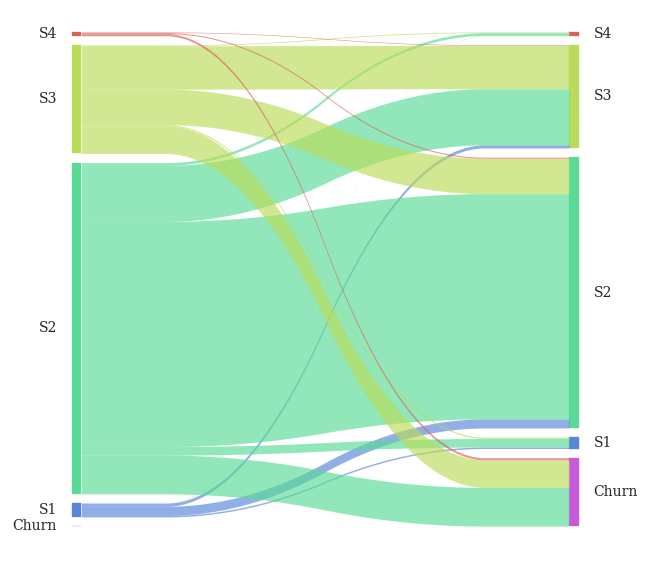

In [105]:
leftLabels = ['Churn', 'S1', 'S2', 'S3', 'S4']
rightLabels = ['Churn', 'S1', 'S2', 'S3', 'S4']
sankey.sankey(df_transition_prob['cfrom'], df_transition_prob['cto'], leftWeight=df_transition_prob['count'], 
              leftLabels=leftLabels, rightLabels=rightLabels, aspect=20, rightColor=False)
plt.gcf().set_size_inches(10,10)

## Feature distribution for each state